In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/pca')

if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True) 

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 10

# Load data

In [3]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

## Scale Inputs

In [4]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.910260     0.242342
1  0.003003  0.910221     0.242544
2  0.005005  0.910181     0.242750
3  0.006961  0.910142     0.242959
4  0.009009  0.910102     0.243172


# Magnetic Field - B [G]

In [5]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

array([0.9102603 , 0.9102209 , 0.91018141, 0.91014183, 0.91010218])

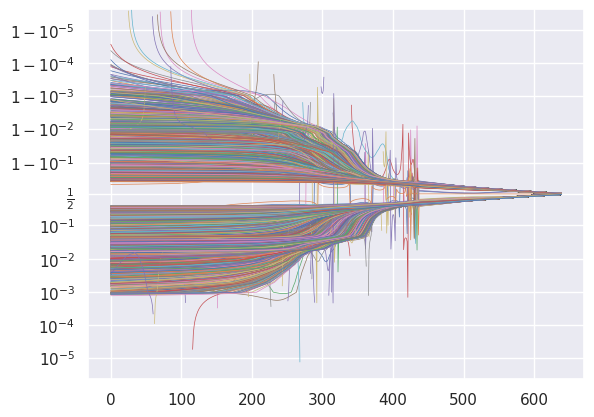

In [6]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('logit')

## PCA

In [7]:
pca = PCA(n_components=2)
transformed_mag = pca.fit_transform(scaled_magnetic)
transformed_mag

array([[-7.32993359, -0.11757823],
       [-8.13654083, -0.23700327],
       [ 5.33655994, -0.40114867],
       ...,
       [ 5.57513388, -0.05081209],
       [ 6.13973441, -0.40265225],
       [ 6.72776225, -0.32598631]])

<AxesSubplot: >

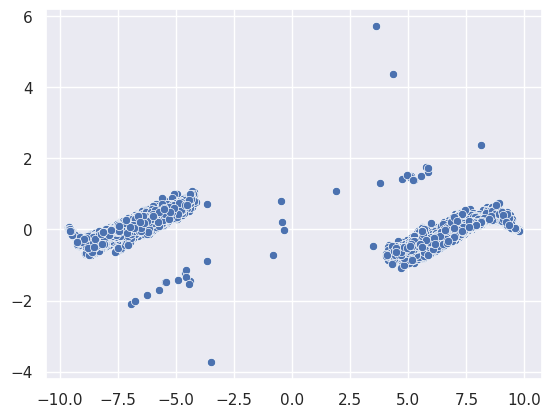

In [8]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

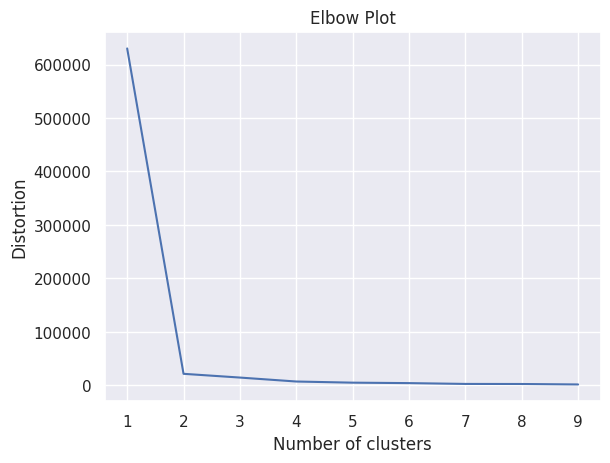

In [9]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [10]:
kmeans = KMeans(n_clusters=8,max_iter=5000)

pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

/home/ivsaav/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

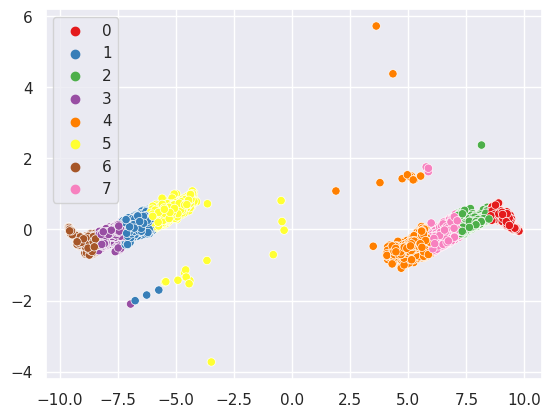

In [11]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

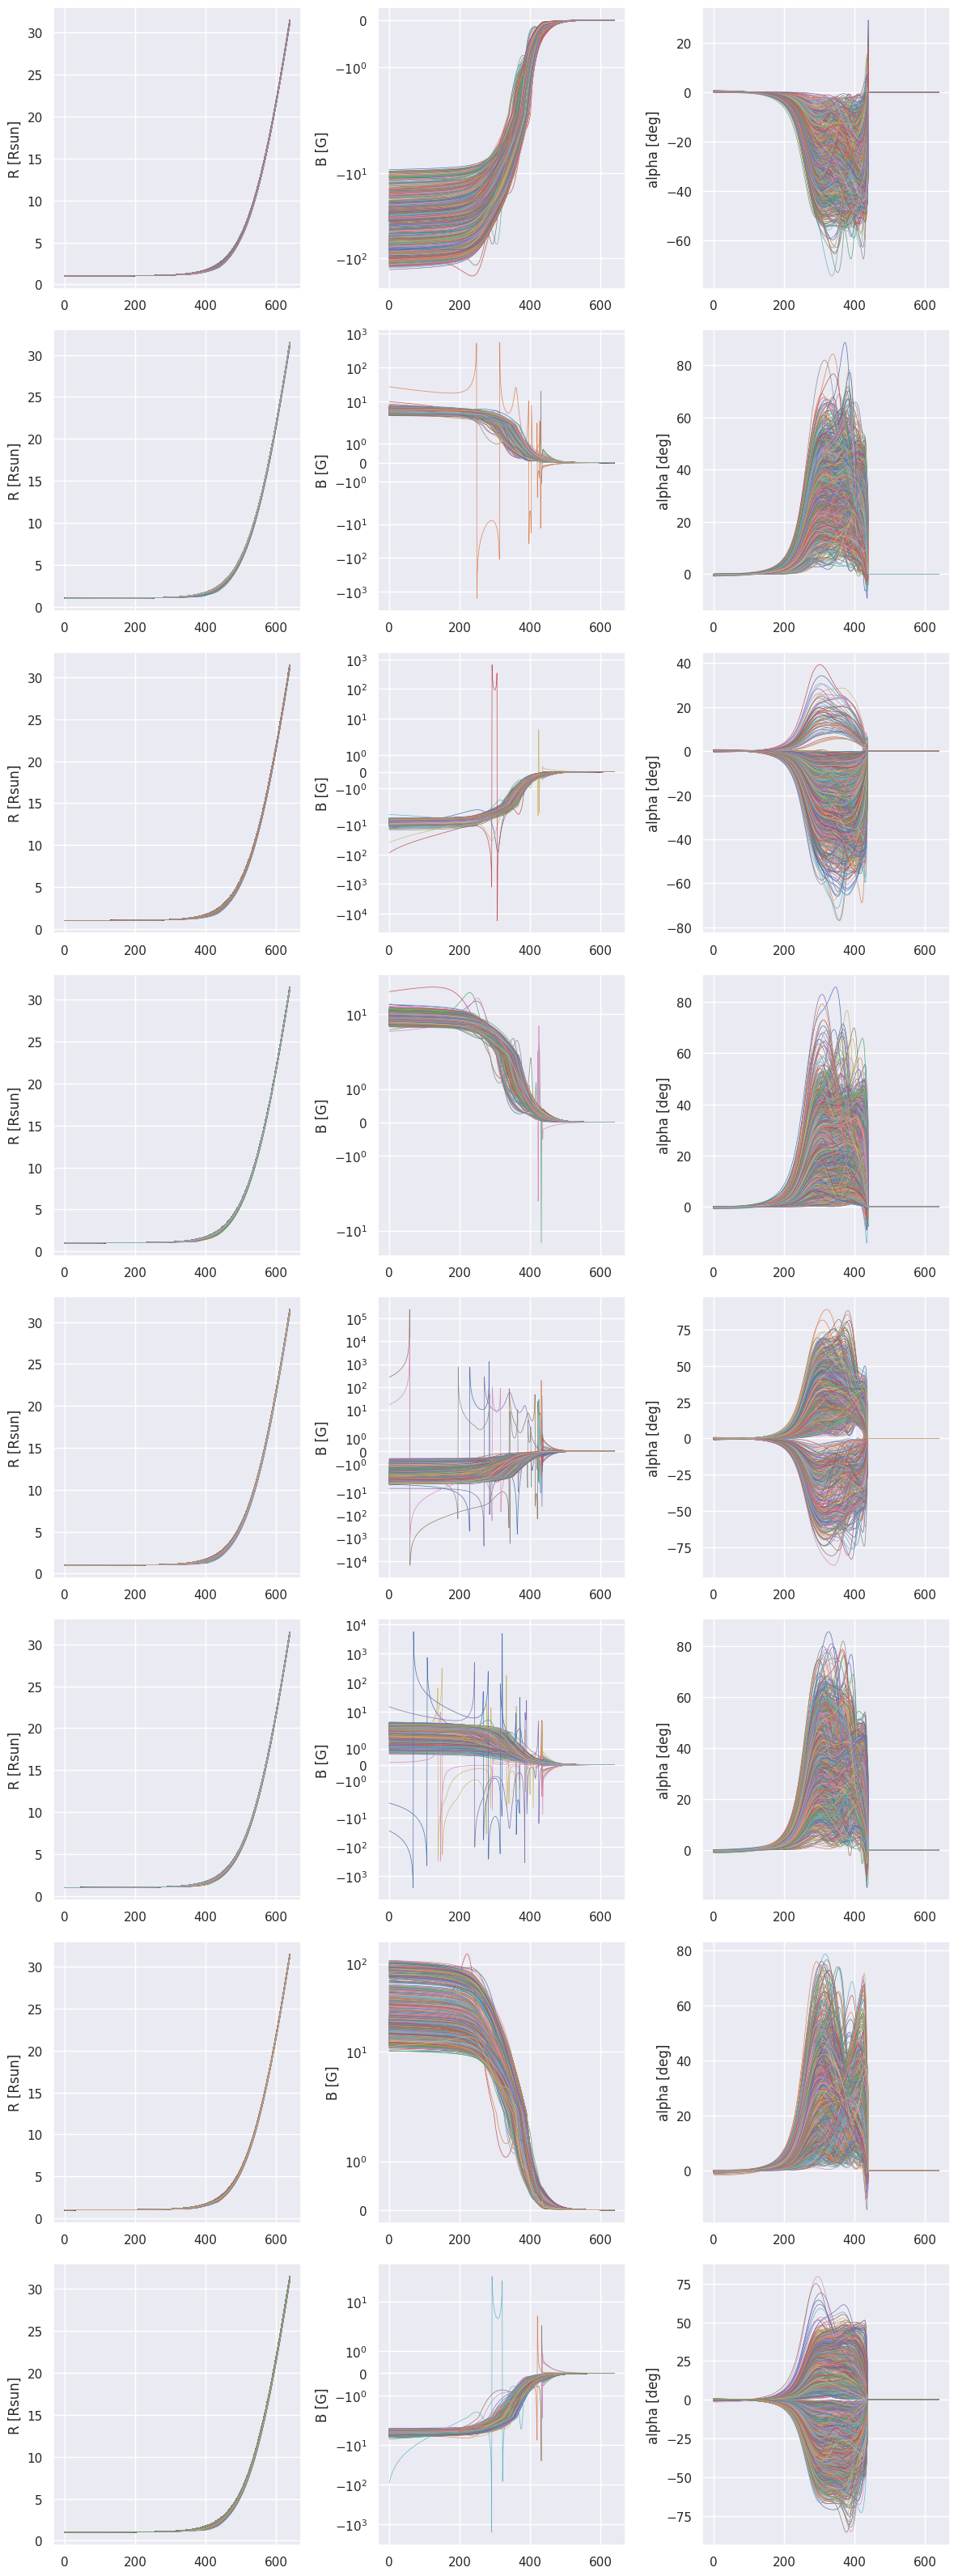

In [14]:
plot_unscaled_clusters(pca_kmeans_mag_labels, 8, flows_dict, flow_columns, yscale={'B [G]': 'symlog'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

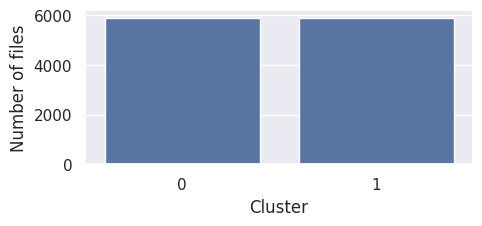

In [12]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [13]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=5, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

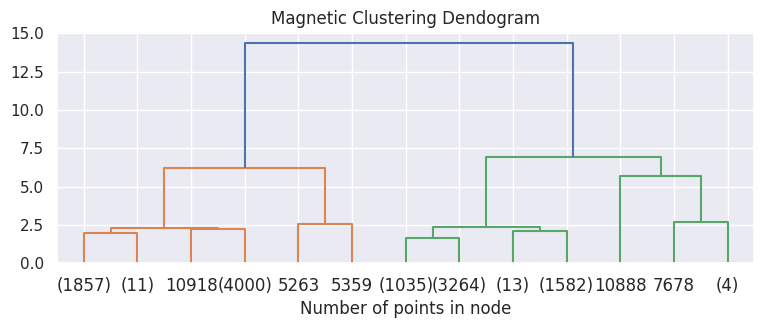

In [14]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

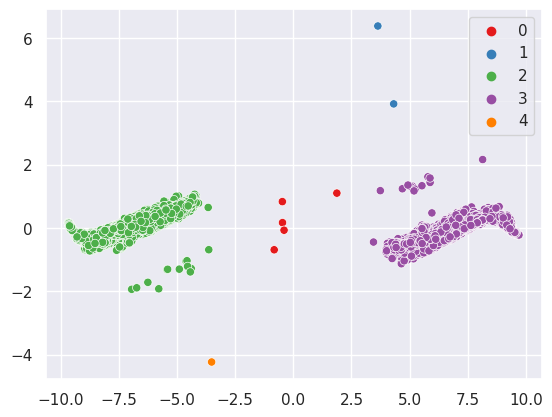

In [15]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))


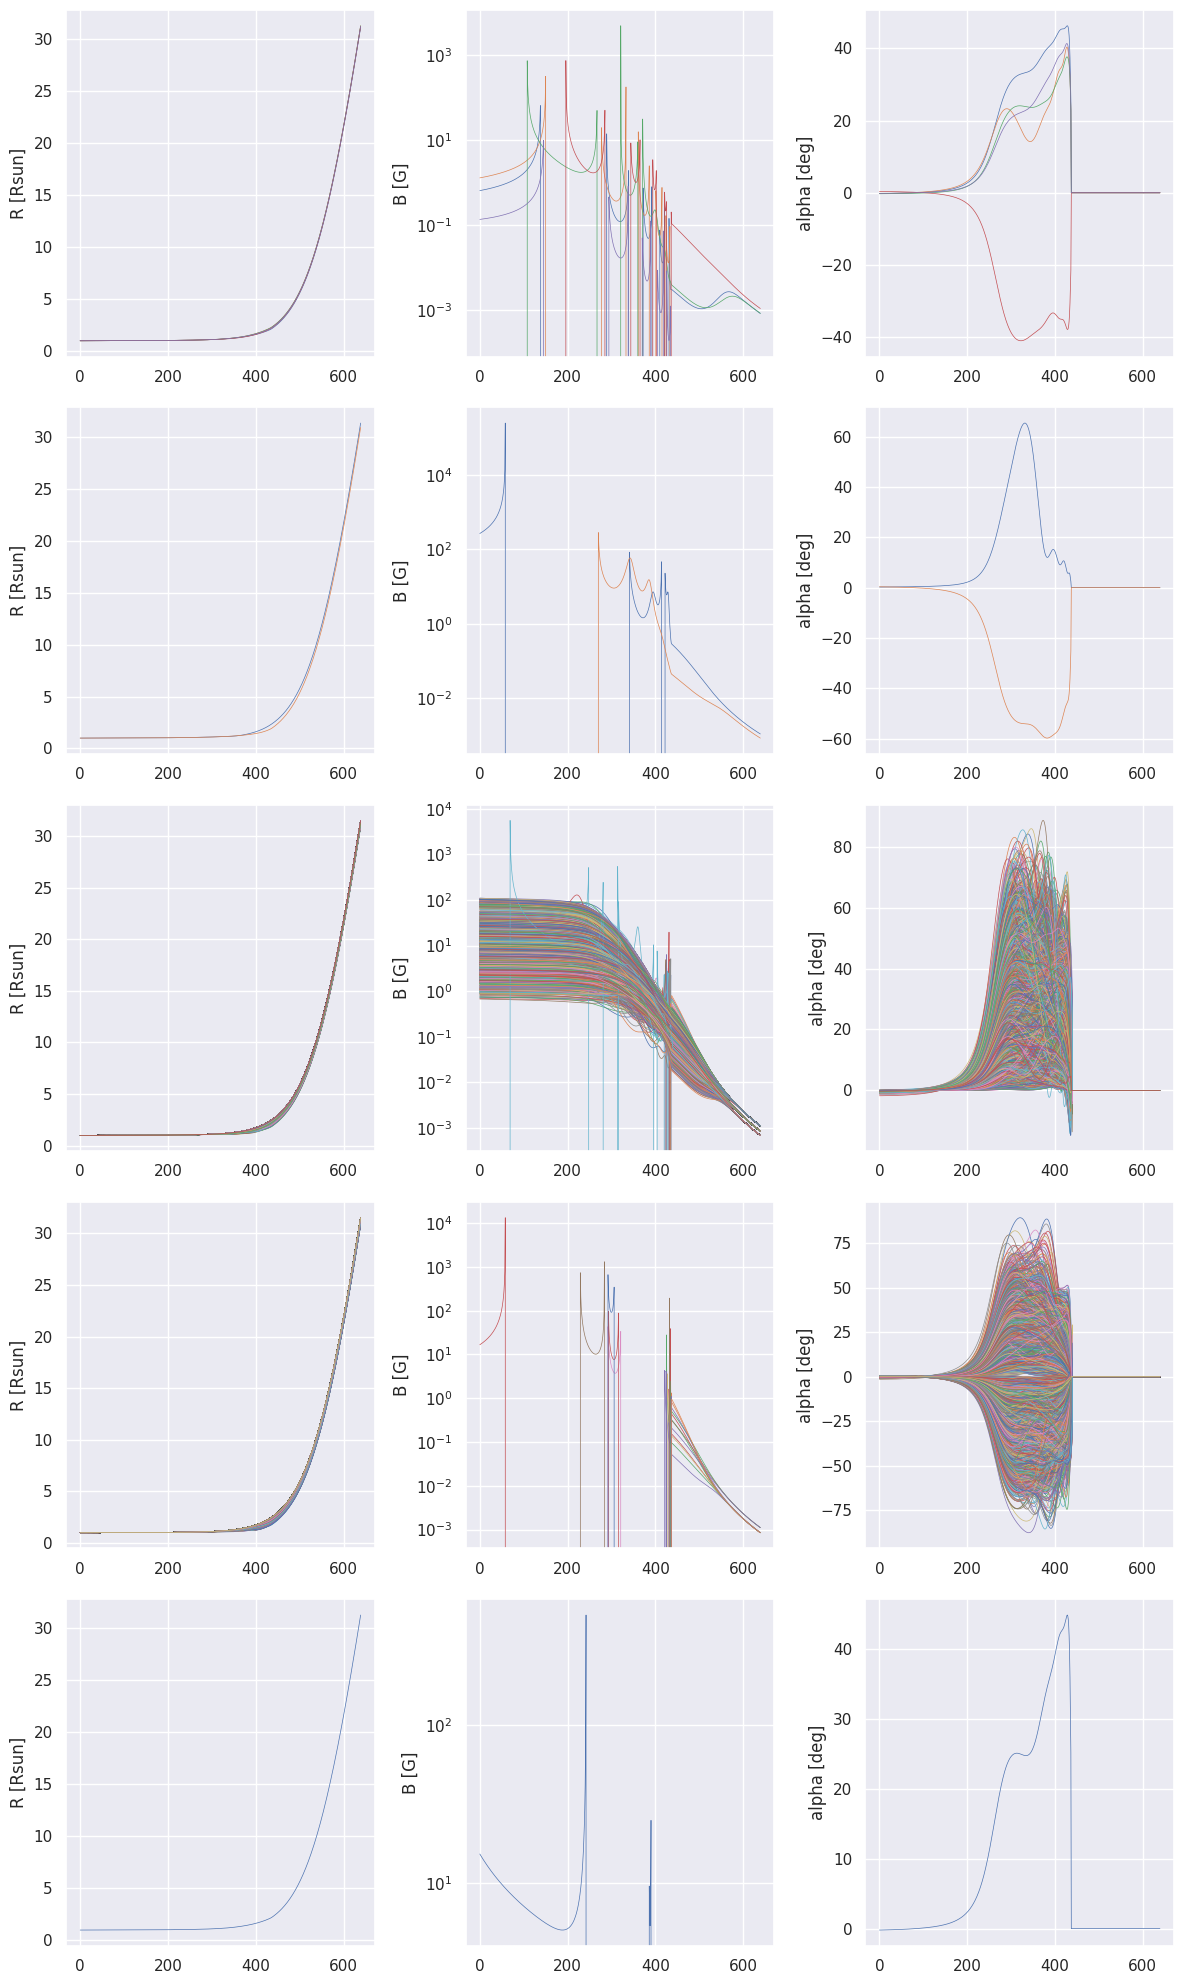

In [16]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

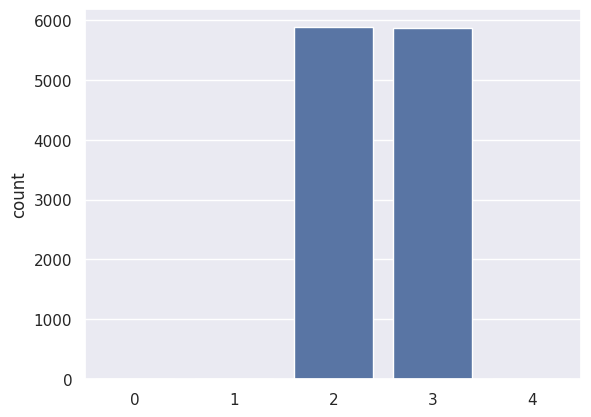

In [17]:
sns.countplot(x=agg.labels_, color='b')

In [18]:
%%capture
sub_dir = OUT_DIR / 'mag'
if not sub_dir.exists():
    sub_dir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_mag)
    
    sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
        
    plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
                           save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'})
    

## DBSCAN

In [19]:
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=2)
dbscan_mag_labels = dbscan.fit_predict(transformed_mag)

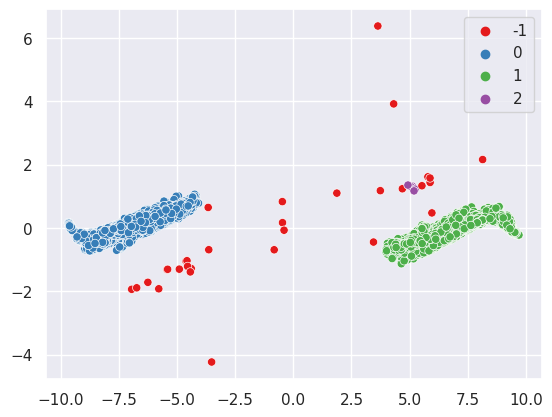

In [20]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))


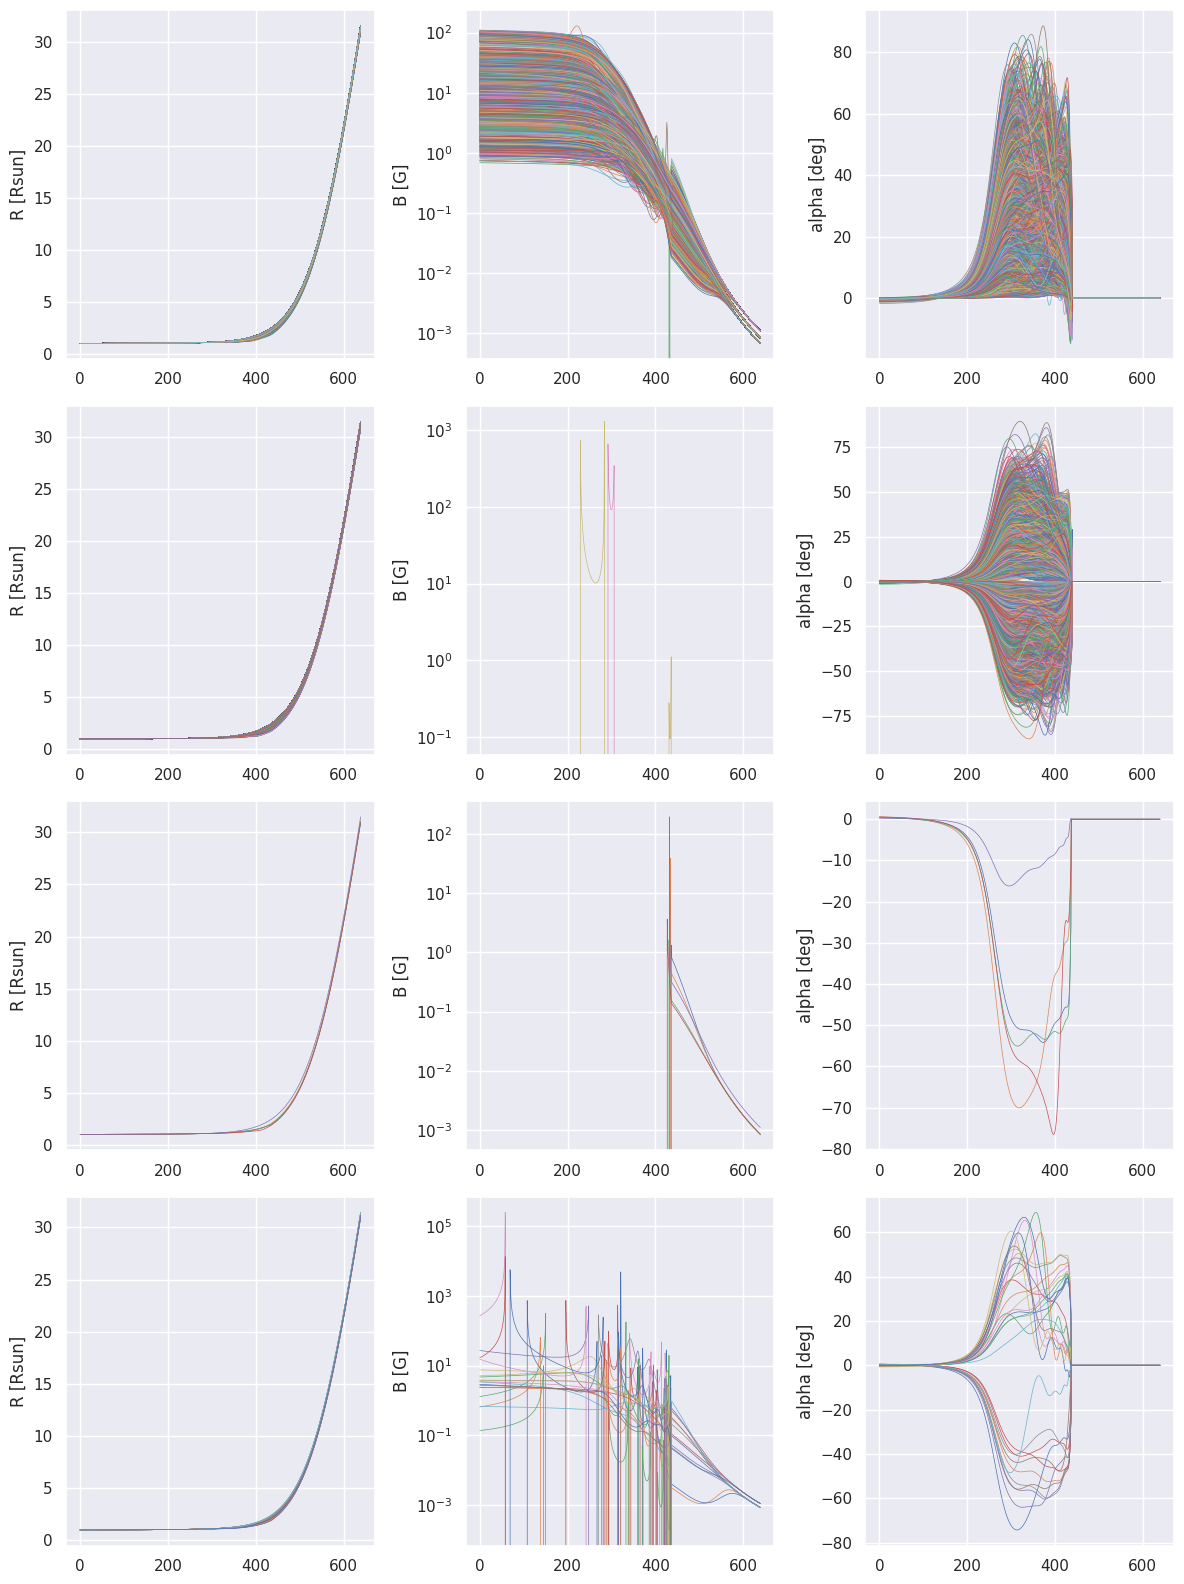

In [21]:
plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

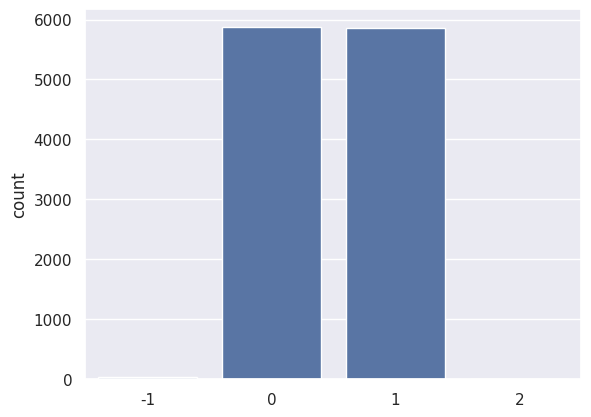

In [22]:
sns.countplot(x=dbscan_mag_labels, color='b')

In [23]:
%%capture
sub_dir = OUT_DIR / 'mag_dbscan'
if not sub_dir.exists():
    sub_dir.mkdir()

for i in np.arange(0.1, 0.35, 0.05):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
    dbscan_mag_labels = dbscan.fit_predict(transformed_mag)
    
    save_i = int(i*100)
    sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
    plt.legend(loc='upper right')
    plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
    plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, 
                           save_path=sub_dir / f'dbscan_{save_i}.png', yscale={'B [G]': 'log'})
    

# Flux Tube Inclination - alpha [deg]

In [24]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.24508171, 0.24530158, 0.24547073, 0.24564296, 0.2458183 ])

## PCA

In [25]:
pca = PCA(n_components=2)
transformed_alpha = pca.fit_transform(scaled_alpha)
transformed_alpha

array([[-4.91466183,  0.53952213],
       [-5.19298976, -1.1154641 ],
       [ 8.86102653, -0.78990602],
       ...,
       [-5.99378222,  0.04688713],
       [ 9.11525142,  1.31994317],
       [ 8.03632376,  1.17579064]])

### Transformed

<AxesSubplot: >

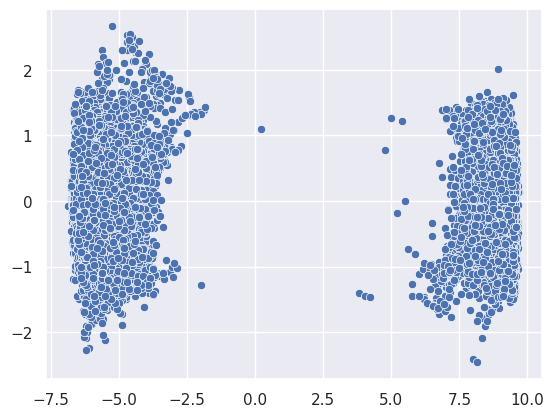

In [26]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

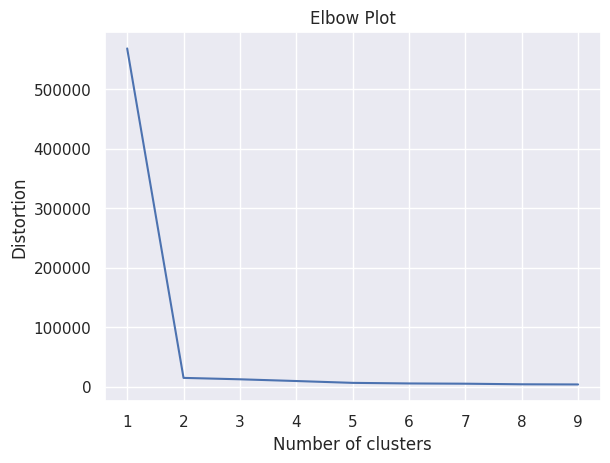

In [27]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [28]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

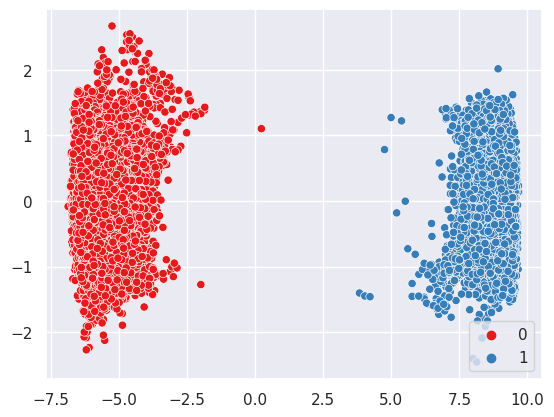

In [29]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))


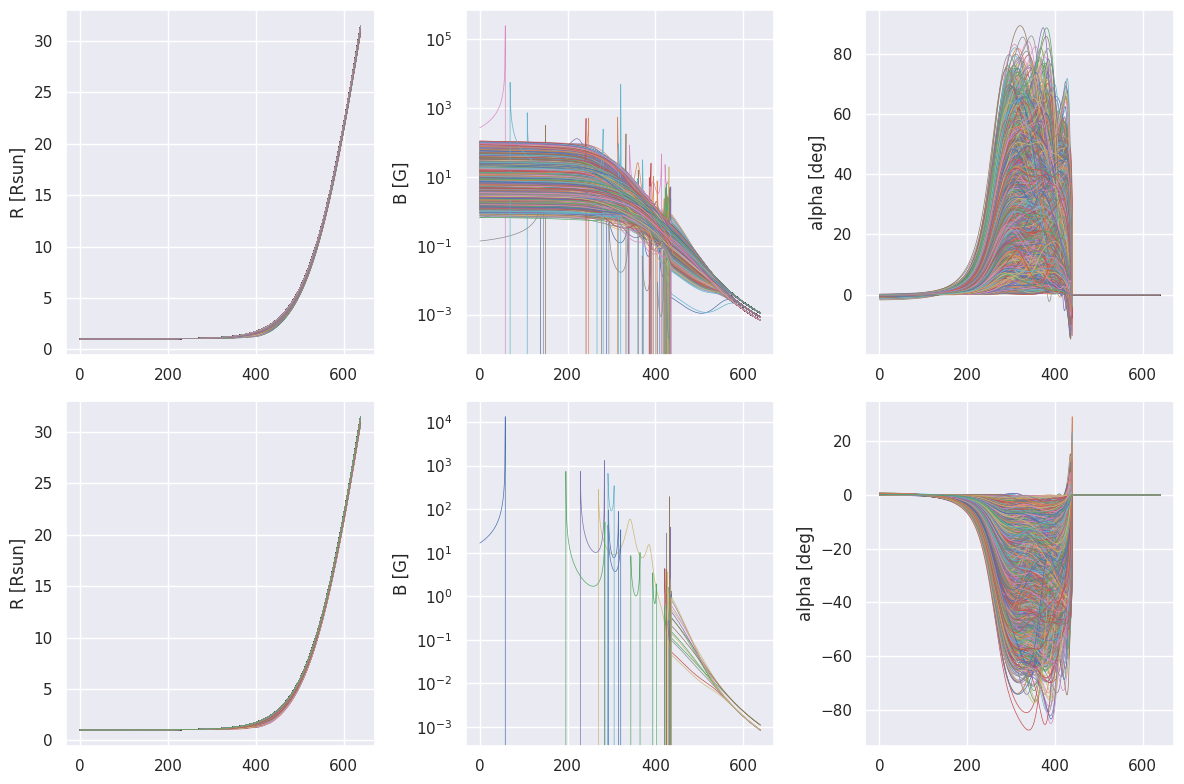

In [30]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, 2, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

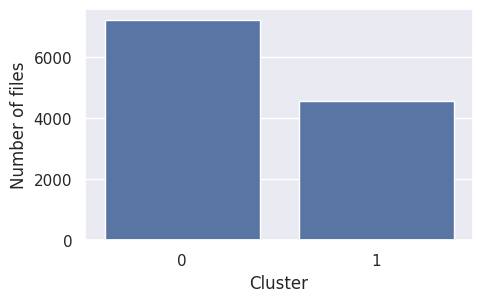

In [31]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [32]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')

agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

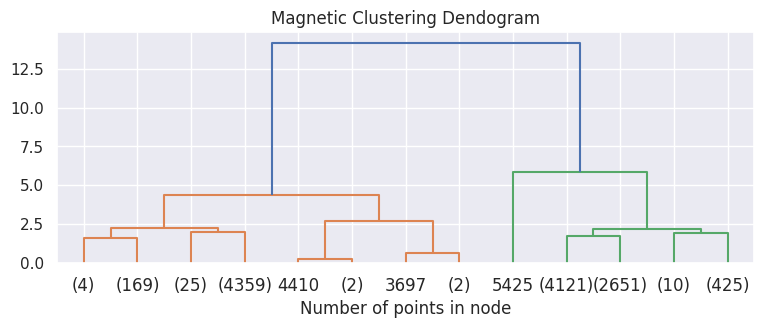

In [33]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

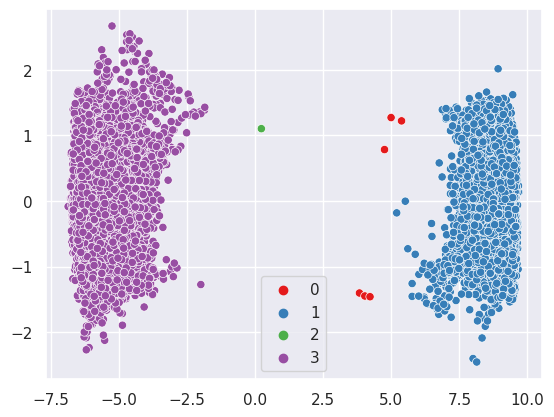

In [34]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))
/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:50: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


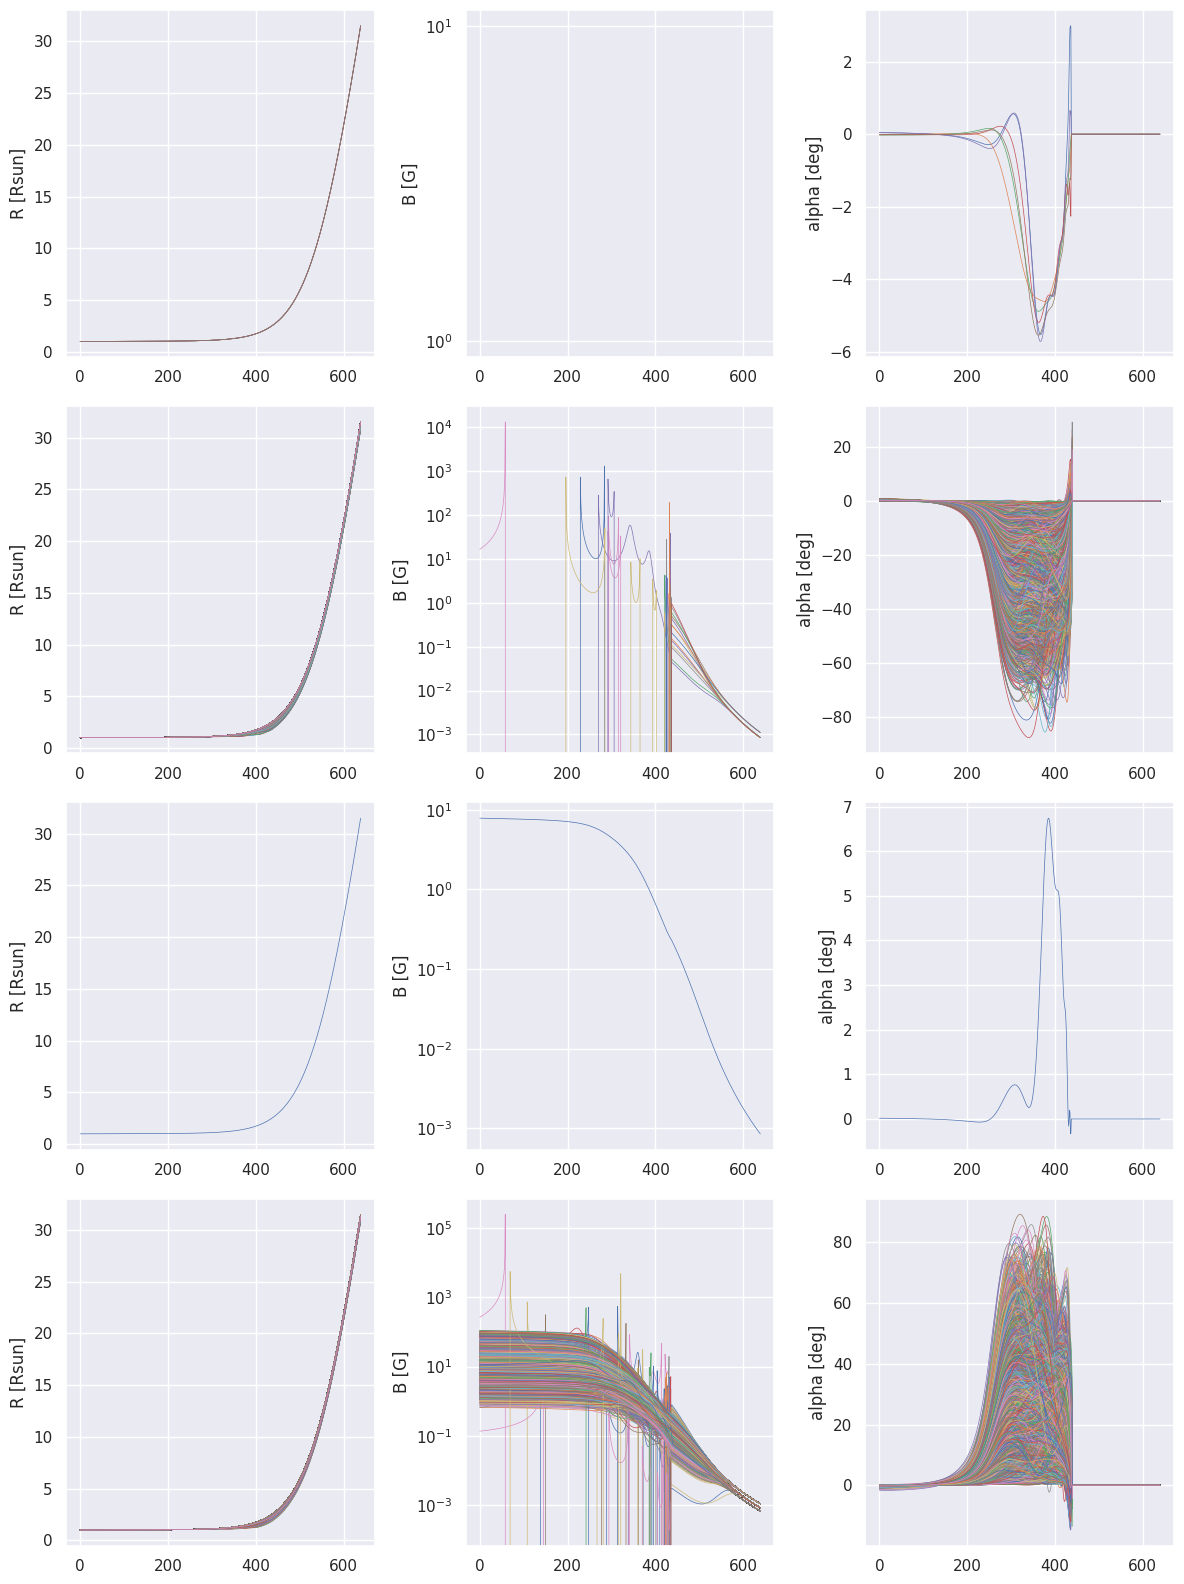

In [35]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

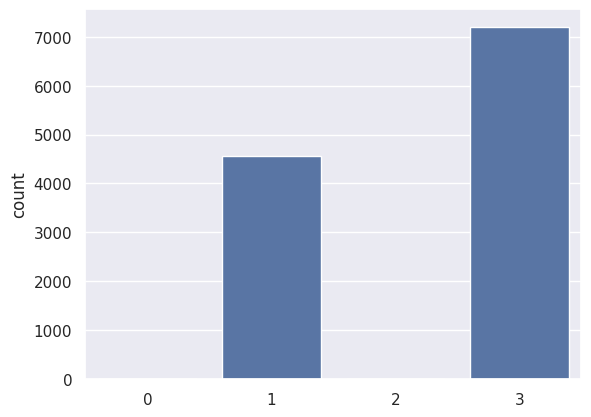

In [36]:
sns.countplot(x=agg.labels_, color='b')

In [37]:
%%capture
sub_dir = OUT_DIR / 'alpha'
if not sub_dir.exists():
    sub_dir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_alpha)
    
    sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
    plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
                           save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [38]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)


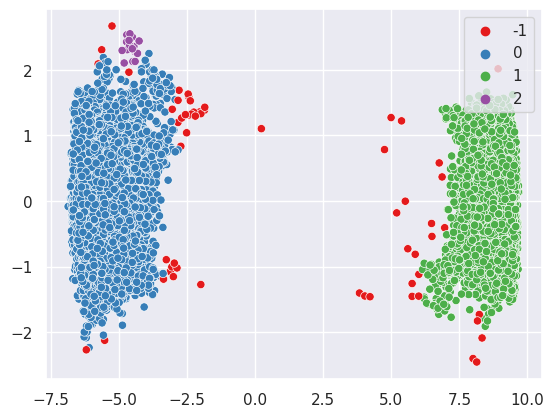

In [39]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

/home/ivsaav/Projects/solarGAN/clustering/notebooks/tools.py:48: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[(labels[idx], col_pos)].set(ylabel=col, yscale=yscale.get(col, 'linear'))


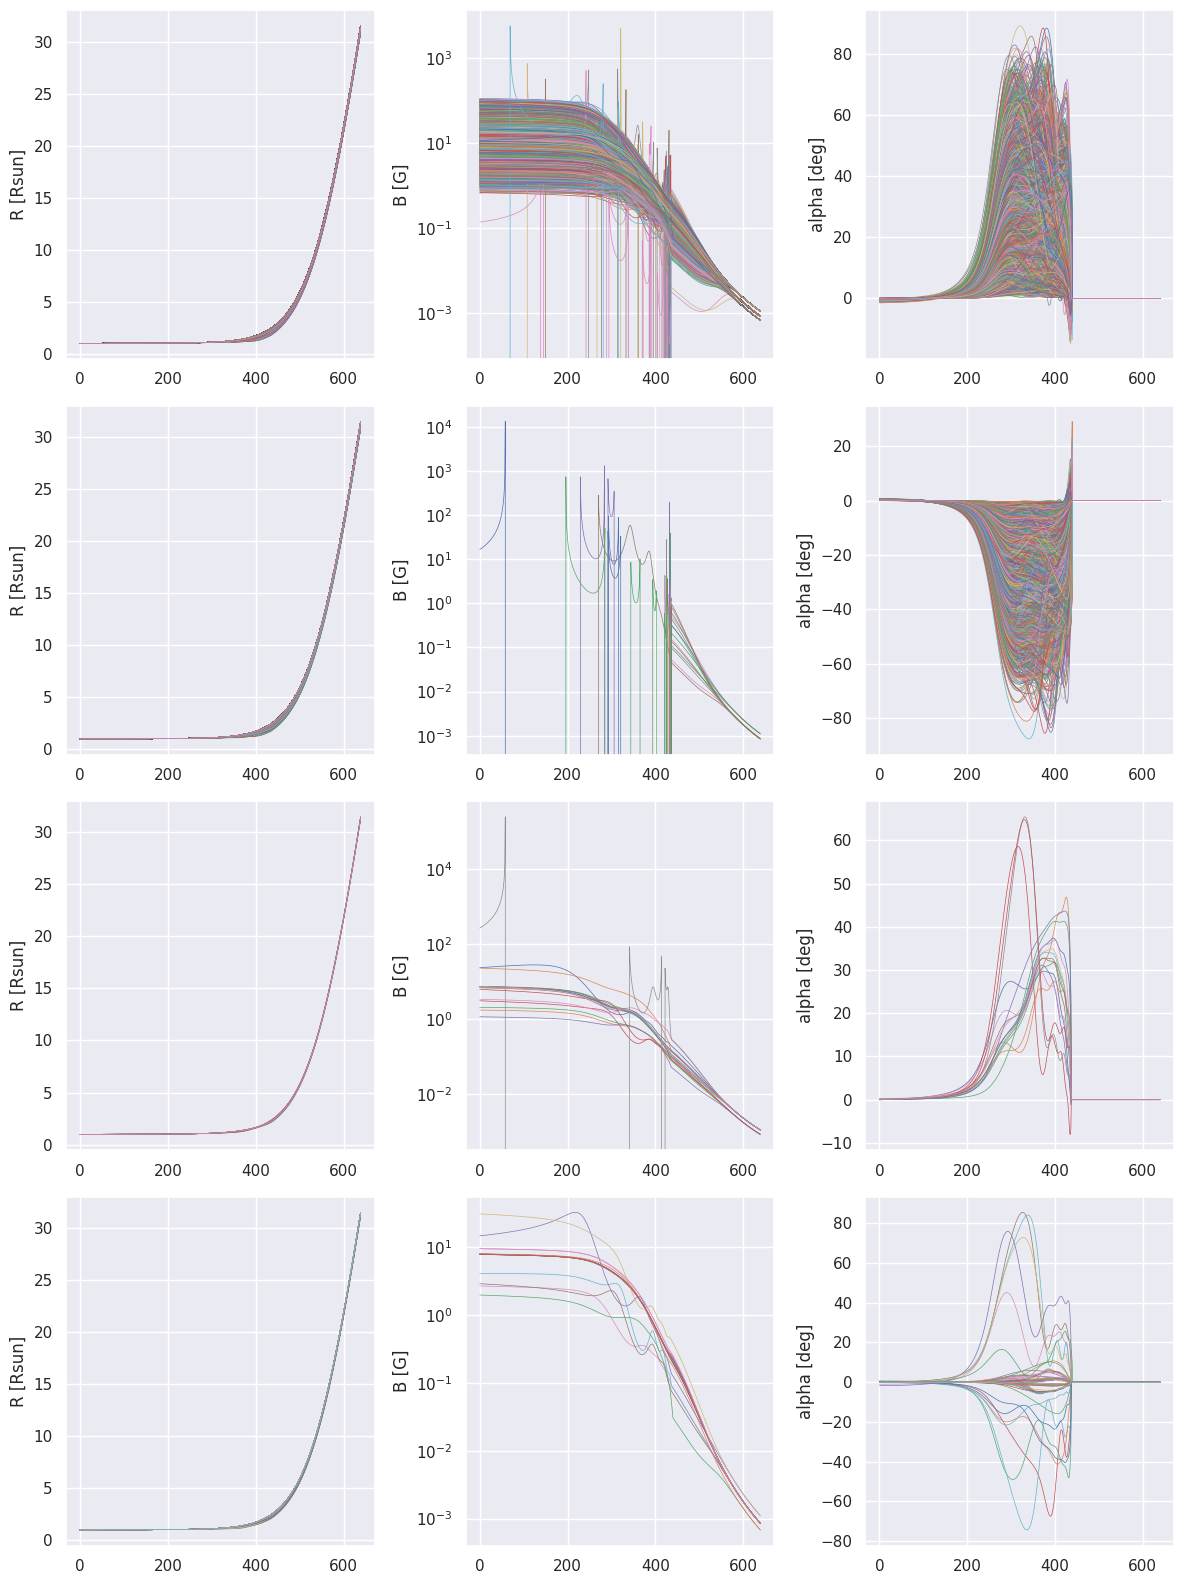

In [40]:
plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

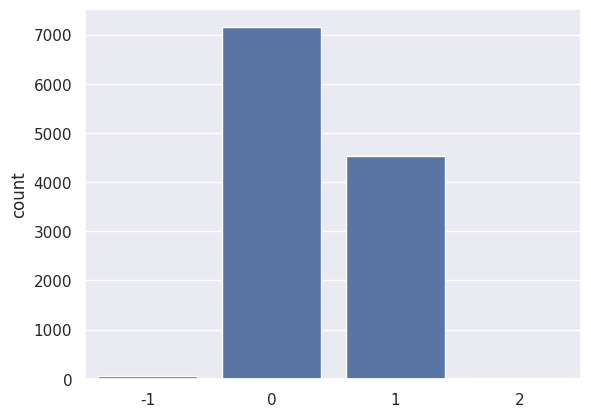

In [41]:
sns.countplot(x=dbscan_alpha_labels, color='b')

In [42]:
%%capture
sub_dir = OUT_DIR / 'alpha_dbscan'
if not sub_dir.exists():
    sub_dir.mkdir()
for i in np.arange(0.2, 0.5, 0.05):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
    dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
    save_i = int(round(i, 2) *100)
    sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
    plt.legend(loc='upper right')
    plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
    plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, 
                           save_path=sub_dir / f'dbscan_{save_i}.png', yscale={'B [G]': 'log'})
    